In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import BayesianRidge

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score


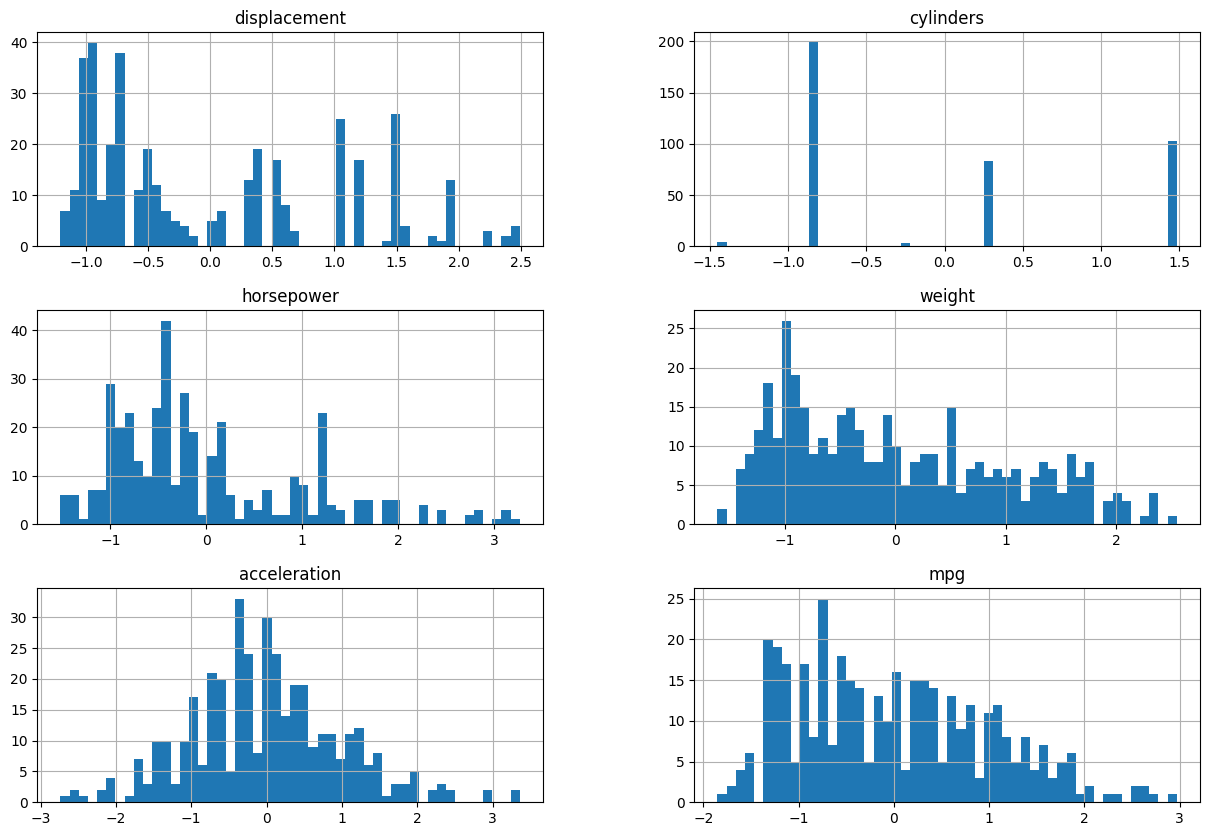

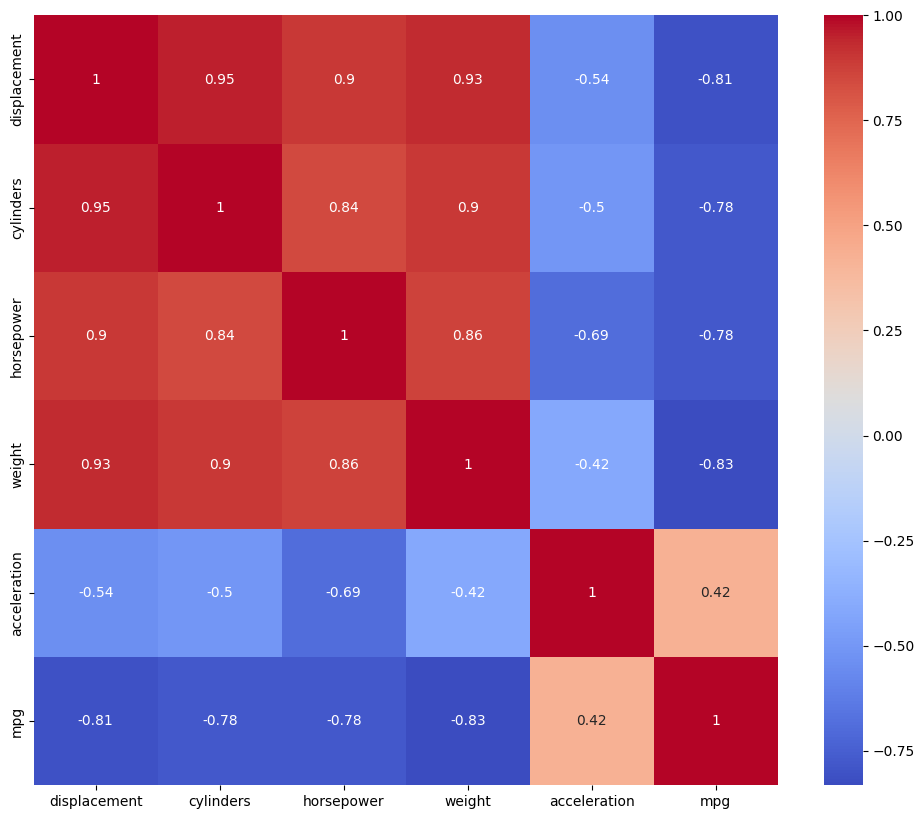

In [112]:
df = pd.read_csv('./auto_1993_adj.csv')
# df.isnull().sum() 6 rows missing horsepower value. Drop those rows
df_dropnull = df.dropna().reset_index(drop=True)

df_dropnull.duplicated().value_counts() # No duplicates

cat_columns = ["ID", "model_year", "origin"] # Remove non-quantity features prior to scaling
cat_df = df_dropnull[cat_columns].reset_index(drop=True)
df_subset = df_dropnull.drop(columns=cat_columns) 

scaler = preprocessing.StandardScaler()
df_scaled_vals = scaler.fit_transform(df_subset)
df_scaled = pd.DataFrame(df_scaled_vals, columns=df_subset.columns)

df_final = pd.concat([cat_df, df_scaled], axis=1) # Restore non-quantity features
df_final = df_final.drop(columns="ID")

# print(df_final.info())
df_scaled.hist(bins=50, figsize=(15,10))
corr_matrix = df_scaled.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

displacement    0.784766
weight          0.779890
horsepower      0.724651
cylinders       0.608235
model_year      0.371876
acceleration    0.205707
origin          0.199931
Name: MI Scores, dtype: float64


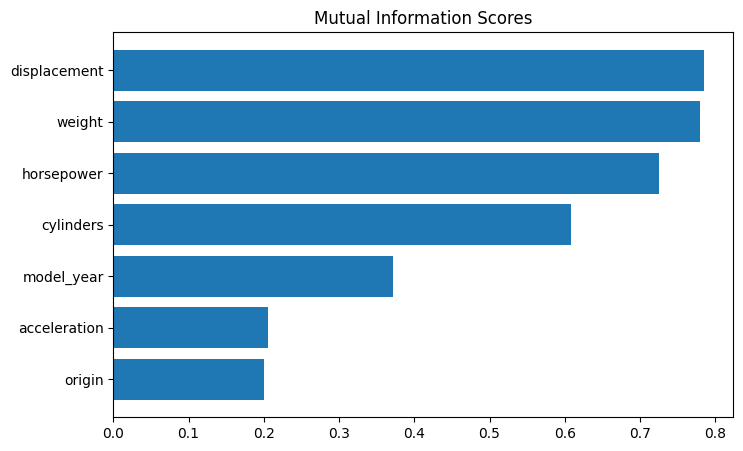

In [104]:
# Split original feature set
X = df_final.drop(["mpg"], axis=1)
y = df_final.mpg

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=16)

# Mutual Info
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = np.array([True, True, False, False, False, False, False])

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores)
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)


In [145]:
# Function to run models on each feature set
def run_models(df):
    X = df.drop(["mpg"], axis=1)
    y = df.mpg

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=16)

    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)

    lsvr_model = LinearSVR(dual='auto')
    lsvr_model.fit(X_train, y_train)
    lsvr_pred = lsvr_model.predict(X_test)

    ridge_model = BayesianRidge()
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)

    # Metrics
    mae_knn = mean_absolute_error(y_test, knn_pred)
    mse_knn = mean_squared_error(y_test, knn_pred)
    r2_knn = r2_score(y_test, knn_pred)

    mae_svr = mean_absolute_error(y_test, lsvr_pred)
    mse_svr = mean_squared_error(y_test, lsvr_pred)
    r2_svr = r2_score(y_test, lsvr_pred)

    mae_ridge = mean_absolute_error(y_test, ridge_pred)
    mse_ridge = mean_squared_error(y_test, ridge_pred)
    r2_ridge = r2_score(y_test, ridge_pred)

    knn_cv = -1 * cross_val_score(knn_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    lsvr_cv = -1 * cross_val_score(lsvr_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    ridge_cv = -1 * cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()

    print("MAE, MSE, R^2, CV-MAE (avg)")
    print("KNN")
    print(mae_knn, mse_knn, r2_knn, knn_cv)
    print("LinearSVR")
    print(mae_svr, mse_svr, r2_svr, lsvr_cv)
    print("Ridge")
    print(mae_ridge, mse_ridge, r2_ridge, ridge_cv)

In [143]:
# Feature Set 1: All features of original dataset
set1 = run_models(df_final)
set1

/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MAE, MSE, R^2, CV-MAE (avg)
KNN
0.29762493648293814 0.16451838760677595 0.8631842914901408 0.3327184237444486
LinearSVR
0.3888157267360623 0.3107814106949769 0.7415499901594249 0.41072986877086387
Ridge
0.34405096783046735 0.21606966964087823 0.8203135505432682 0.38721346411014


/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [154]:
# Feature Set 2: displacement, horsepower
df_2 = df_final.copy()
selection = ["displacement", "horsepower", "mpg"]
df_run = df_2[selection].copy()
set2 = run_models(df_run)
set2

MAE, MSE, R^2, CV-MAE (avg)
KNN
0.42138224425518034 0.3774808709509719 0.6860818200363346 0.4278811066764277
LinearSVR
0.46607608396706185 0.42516875944906335 0.6464239292247618 0.5218041000385688
Ridge
0.45594984339523453 0.39548249556391274 0.6711114263826189 0.5185186295981854


In [153]:
# Feature Set 3: displacement, horsepower, cylinders, weight
df_3 = df_final.copy()
selection = ["displacement", "horsepower", "cylinders", "weight", "mpg"]
df_run = df_3[selection].copy()
set3 = run_models(df_run)
set3

MAE, MSE, R^2, CV-MAE (avg)
KNN
0.40302940466382375 0.33671992102889453 0.7199791753669325 0.42672915037407166
LinearSVR
0.46701939587191793 0.4265372572827862 0.645285867981647 0.48441385568312595
Ridge
0.4364471435857886 0.36645274478565615 0.6952529583923104 0.4906452447503719


/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [152]:
# Feature Set 4: horsepower per cylinder, avg displacement by origin, origin frequency

df_4 = df_final.copy()
df_4["hp_per_cyl"] = df_4.horsepower / df_4.cylinders

df_4["average_origin_disp"] = (
    df_4.groupby("origin")
    ["displacement"]
    .transform("mean")
)

df_4["origin_freq"] = (
    df_4.groupby("origin")
    ["origin"]
    .transform("count")
    / df_4.origin.count()
)

selection = ["hp_per_cyl", "average_origin_disp", "origin_freq", "mpg"]
df_run = df_4[selection].copy()
set4 = run_models(df_run)
set4

MAE, MSE, R^2, CV-MAE (avg)
KNN
0.616953872996168 0.6189860213425287 0.4852428819683562 0.6383053744013376
LinearSVR
0.7172136916041435 0.7888996888270271 0.34394038599469146 0.779388674337389
Ridge
0.7142623096906755 0.7394310420313025 0.3850791794076065 0.7567893302112982


In [150]:
# Feature Set 5: displacement, avg displacement by model year, model year
df_5 = df_final.copy()
df_5["avg_disp_by_year"] = (
    df_5.groupby("model_year")
    ["displacement"]
    .transform("mean")
)

selection = ["displacement", "avg_disp_by_year", "model_year", "mpg"]
df_run = df_5[selection].copy()
set5 = run_models(df_run)
set5

MAE, MSE, R^2, CV-MAE (avg)
KNN
0.32262773507030673 0.17223196291952503 0.8567695782966201 0.4177782342200384
LinearSVR
0.4520346928587836 0.31311042735117384 0.7396131485176841 0.5177286297269902
Ridge
0.4224183297224974 0.297998239807879 0.752180647360498 0.45383011742437046


/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [151]:
# Feature Set 6: avg acceleration by cylinders, horsepower, weight, displacement
df_6 = df_final.copy()
df_6["avg_accel_by_cyls"] = (
    df_6.groupby("cylinders")
    ["acceleration"]
    .transform("mean")
)

selection = ["avg_accel_by_cyls", "horsepower", "weight", "displacement", "mpg"]
df_run = df_6[selection].copy()
set6 = run_models(df_run)
set6

MAE, MSE, R^2, CV-MAE (avg)
KNN
0.4059354891069629 0.3390092537024218 0.7180753354600399 0.4274864619199132
LinearSVR
0.4705598995026909 0.4010457163935896 0.6664849769596628 0.48437101181129993
Ridge
0.44563665170587874 0.36683076582083207 0.694938591004497 0.48863102589448
